In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
# Создаем классы для каждого блока UNet

# Класс для двух последовательных сверток с функцией активации ReLU
class DoubleConv1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv1d, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Класс для уменьшения размерности входного тензора вдвое
class Down1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down1d, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1d(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Класс для увеличения размерности входного тензора вдвое
class Up1d(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up1d, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        else:
            self.up = nn.ConvTranspose1d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv1d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, [diff // 2, diff - diff // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Класс для выходного слоя
class OutConv1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс для всей сети UNet
class UNet1d(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet1d, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv1d(n_channels, 64)
        self.down1 = Down1d(64, 128)
        self.down2 = Down1d(128, 256)
        self.down3 = Down1d(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down1d(512, 1024 // factor)
        self.up1 = Up1d(1024, 512 // factor, bilinear)
        self.up2 = Up1d(512, 256 // factor, bilinear)
        self.up3 = Up1d(256, 128 // factor, bilinear)
        self.up4 = Up1d(128, 64, bilinear)
        self.outc = OutConv1d(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Создаем экземпляр модели и выводим ее архитектуру
model = UNet1d(n_channels=1, n_classes=1) 
print(model)

UNet1d(
  (inc): DoubleConv1d(
    (double_conv): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down1d(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1d(
        (double_conv): Sequential(
          (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down1d(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1d(
        (double_conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
       

In [13]:
# Пример класса датасета
class ExampleDataset(Dataset):
    def __init__(self, filedata, filetargets, if_test=False):
        # Загрузка данных
        DATA = torch.load(filedata)
        TARGETS = torch.load(filetargets)
        # Преобразование данных во float
        DATA, TARGETS = torch.tensor(DATA).float().unsqueeze(1), torch.tensor(TARGETS).float().unsqueeze(1)
        # Выбор 80% данных для обучения или 20% для тестирования
        data_n = 0.8 * len(DATA)
        if if_test == False:
            self.data = DATA[:int(data_n)]
            self.targets = TARGETS[:int(data_n)]
        else:
            self.data = DATA[int(data_n):]
            self.targets = TARGETS[int(data_n):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Создание датасета и загрузчика данных
folder = "/Users/shuramakarenko/LocalDocs/Workspace/Neiro_toyeplitz/DATA/Matrix1024"
filedata = folder + "/Samples.pth"
filetargets = folder + "/Targets.pth"
dataset = ExampleDataset(filedata, filetargets)
datatest = ExampleDataset(filedata, filetargets, if_test=True)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
dataloader_test = DataLoader(datatest, batch_size=10, shuffle=True)

# Создание модели
model = UNet1d(n_channels=1, n_classes=1)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
num_epochs = 10
train_losses = []
test_losses = []
test_mape = []
test_r2 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, targets)  # Вычисление потерь
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновление параметров
        running_loss += loss.item()
    
    train_loss = running_loss / len(dataloader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Оценка на тестовой выборке
    model.eval()  # Перевод модели в режим оценки
    test_loss = 0.0
    all_targets = []
    all_outputs = []
    with torch.no_grad():  # Отключение вычисления градиентов
        for inputs, targets in dataloader_test:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            all_targets.extend(targets.squeeze(1).numpy())
            all_outputs.extend(outputs.squeeze(1).numpy())
    
    test_loss /= len(dataloader_test)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Вычисление MAPE и R²
    print
    mape = mean_absolute_percentage_error(all_targets, all_outputs)
    r2 = r2_score(all_targets, all_outputs)
    test_mape.append(mape)
    test_r2.append(r2)
    print(f'Epoch {epoch+1}/{num_epochs}, Test MAPE: {mape}, Test R²: {r2}')

print("Обучение завершено")


/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_5612/2391554475.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DATA = torch.load(filedata)[::10]
/var/folders

Epoch 1/10, Training Loss: 0.00035554474883952024
Epoch 1/10, Test Loss: 1.822219101086375e-05
Epoch 1/10, Test MAPE: 658112359.57625, Test R²: -2226743740630.091


100%|██████████| 80/80 [00:07<00:00, 10.55it/s]


Epoch 2/10, Training Loss: 1.2457624991668581e-05
Epoch 2/10, Test Loss: 7.441244235906197e-06
Epoch 2/10, Test MAPE: 1725849513.6321325, Test R²: -15313556554981.566


100%|██████████| 80/80 [00:07<00:00, 11.12it/s]


Epoch 3/10, Training Loss: 9.048211057915979e-06
Epoch 3/10, Test Loss: 1.3954907444713172e-06
Epoch 3/10, Test MAPE: 720179566.9347539, Test R²: -2666562589786.9004


100%|██████████| 80/80 [00:07<00:00, 10.88it/s]


Epoch 4/10, Training Loss: 5.012788932390322e-07
Epoch 4/10, Test Loss: 1.7669401888298353e-07
Epoch 4/10, Test MAPE: 209703388.66738203, Test R²: -226089941661.62634


100%|██████████| 80/80 [00:07<00:00, 10.62it/s]


Epoch 5/10, Training Loss: 1.7195662320723671e-07
Epoch 5/10, Test Loss: 1.074303877857119e-07
Epoch 5/10, Test MAPE: 192327071.87844914, Test R²: -190174036837.85184


100%|██████████| 80/80 [00:07<00:00, 11.02it/s]


Epoch 6/10, Training Loss: 1.2234323043536222e-07
Epoch 6/10, Test Loss: 8.319974003079267e-08
Epoch 6/10, Test MAPE: 133978908.75533459, Test R²: -92290000942.2988


100%|██████████| 80/80 [00:07<00:00, 11.24it/s]


Epoch 7/10, Training Loss: 1.1040598789646694e-07
Epoch 7/10, Test Loss: 8.044425285902434e-08
Epoch 7/10, Test MAPE: 306679486.1055826, Test R²: -483548051030.36475


100%|██████████| 80/80 [00:07<00:00, 11.32it/s]


Epoch 8/10, Training Loss: 1.2426093636275227e-07
Epoch 8/10, Test Loss: 8.005059957127968e-08
Epoch 8/10, Test MAPE: 347151295.3024084, Test R²: -619589704985.7743


100%|██████████| 80/80 [00:07<00:00, 10.84it/s]


Epoch 9/10, Training Loss: 1.044850582831991e-07
Epoch 9/10, Test Loss: 7.228197338449149e-08
Epoch 9/10, Test MAPE: 89881809.8709065, Test R²: -41535005237.05378


100%|██████████| 80/80 [00:07<00:00, 11.14it/s]


Epoch 10/10, Training Loss: 1.0197148693213976e-07
Epoch 10/10, Test Loss: 6.68067164033559e-08
Epoch 10/10, Test MAPE: 70661604.81862295, Test R²: -25670697631.227272
Обучение завершено


In [16]:
model.eval()
import numpy as np
np.set_printoptions(linewidth=np.inf)
with torch.no_grad():
    for inputs, targets in dataloader_test:
        outputs = model(inputs)
        print(f'Inputs: {inputs.squeeze(1)[0].numpy()[:10]}')
        print(f'Targets: {targets.squeeze(1)[0].numpy()[:10]}')
        print(f'Outputs: {outputs.squeeze(1)[0].numpy()[:10]}')
        break



Inputs: [-7.6258399e-02 -5.3446288e-03 -5.3851597e-04 -1.5426104e-04 -6.4336549e-05 -3.2767777e-05 -1.8909101e-05 -1.1887477e-05 -7.9548845e-06 -5.5827436e-06]
Targets: [-7.6258399e-02 -5.3394097e-03 -5.3746416e-04 -1.5380910e-04 -6.4085238e-05 -3.2607779e-05 -1.8798306e-05 -1.1806214e-05 -7.8927369e-06 -5.5336764e-06]
Outputs: [-7.5812869e-02 -6.3955188e-03 -5.6810677e-04 -4.1089207e-04 -4.4620782e-04 -1.4930218e-04 -1.7210841e-05 -9.1418624e-06 -1.5012920e-05 -1.6845763e-05]


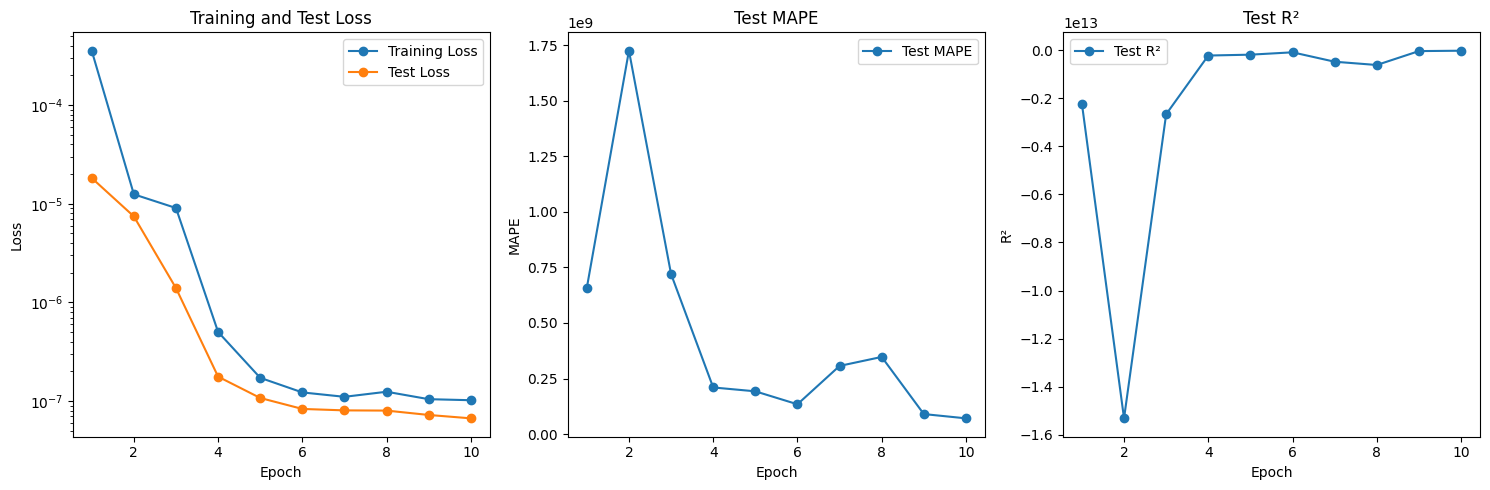

In [15]:
# Построение графиков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), test_mape, label='Test MAPE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.title('Test MAPE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), test_r2, label='Test R²', marker='o')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Test R²')
plt.legend()

plt.tight_layout()
plt.show()